In [32]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib as mlab
import matplotlib.pyplot as plt
import xarray as xr
import os as os
import matplotlib.gridspec as gridspec

import glob
from pathlib import Path

from filter.RaymondFilters import RaymondFilter

import cartopy.crs as ccrs
import cartopy.feature as cfeature

from plot_tools import *

# Local import 

from spectra.py_spectra import *

# Helper functions......

def add_fhour(ds):
    
    filename = ds.encoding["source"].split("_")
    
    init_time = int(filename[-2])
    fhour     = int(filename[-1][-5:-3])
        
    ds.coords['fhour'] = fhour
    ds.coords['init_time'] = init_time
    
    return ds
    
def read_mfdataset_list(data_dir, pattern):
    """
    Use xarray.open_mfdataset to read multiple netcdf files from a list.
    """
    filelist = os.path.join(data_dir,pattern)
    return xr.open_mfdataset(filelist, preprocess=add_fhour, combine='nested', concat_dim=['fhour'],parallel=True)

def save_mfdataset_list(ds, dir, gridType=None):
    """
    Use xarray.save_mfdataset to save multiple netcdf files from a list, using the original file strings as a pattern
    """

    # Use new pathlib for Python > 3.5
    Path(dir).mkdir(parents=True, exist_ok=True)

    for n, hour in enumerate(ds.fhour):
        fcstHour  = ds.isel(fhour=n).fhour.values
        fcstStart = ds.isel(fhour=n).fcstStart
        date      = ds.isel(fhour=n).date      
        
        if gridType == None:
            gridType = ds.isel(fhour=n).attrs['gridType']
            
        outfilename = os.path.join(dir, '%s_%08d%04d_F%02d.nc' % (gridType, date, fcstStart, fcstHour))
        
        ds.isel(fhour=n).to_netcdf(outfilename, mode='w')  
        print(f'Successfully wrote new data to file:: {outfilename}','\n')
    
    return


In [3]:
# Open data sets

def filter_ds(dir, output_dir, prefix, dx = 10, npass = 6, writeout=False, klevels=None, **kwargs):
        
    ds  = read_mfdataset_list(dir , "%s_*.nc" % prefix)
    
    print(ds['W'])

    # Set up cartopy stuff here, so the plot routine is already set to use it.

    fig, axes = init_cartopy_plot(ncols=2, nrows=1, figsize=(20,10))

    # Plot the initial data

    cb_info = plot_w_from_xarray(ds, fhour=4, title='UNFILTERED', ax = axes[0], **kwargs)

    # Convert to numpy arrays, fill in zeros

    w = np.nan_to_num(ds.W.values).astype('float64')

    nhour, nz, ny, nx = w.shape
    
    w_filtered = np.zeros_like(w)

    for n in np.arange(nhour):
        
        print("\n-------------------------------\nFile %d being processed\n" % n)

        w_filtered[n] = RaymondFilter(w[n], dx, klevels=klevels, order=10, npass = npass, fortran = True, highpass=True, width=50)
            
    ds['W'] = xr.DataArray(w_filtered, dims = ['fhour','nz','ny','nx'])

    # Plot the Filtered data

    cb_info = plot_w_from_xarray(ds, fhour=4, title='FILTERED', ax = axes[1], **kwargs)

    if writeout:
        save_mfdataset_list(ds, output_dir, gridType='filtered')
    
    return

In [4]:
# input_config =  {
#               "filtered_filename": "",
#               "filter_dx":          12,
#               "filter_npass":       1,
#               "input_dir":   "/work/larissa.reames",
#               "output_dir":  "/work/wicker/CAM_case_studies",
#               "cases": {
#                         "2020030212": ["ctrl"],
#                         #"2020030212": ["hrrr", "ctrl", "nord3", "nam"],
#                         # "2021052612": ["hrrr", "ctrl", "nord3"],
#                        },
#                "zoom": {
#                         "2019071918": [44.0, 49.0,  -92.0, -87.0, 5],
#                         "2020081006": [39.0, 44.0,  -92.0, -86.0, 5],
#                         "2020030212": [34.0, 39.5,  -92.0, -85.0, 2],
#                         "2021090100": [35.5, 43.0,  -80.0, -73.0, 5],
#                         "2020050300": [35.0, 40.0,  -92.0, -85.0, 5],
#                         "2020070700": [42.0, 46.0, -101.0, -96.0, 5],
#                         "2021052612": [33.5, 43.0, -102.5, -97.0, 5],
#                         # "2021052612": [37.0, 40.5, -100., -97.5, 5]
#                         }
#                    }


====> Begin processing runs

-------> Parameter Filter SCALE: 8 

-------> Parameter        NPASS: 1 

-------> Parameter FILTERED FILE DIRECTORY:  


----> Processing run: hrrr for day:  2020081006 

<xarray.DataArray 'W' (fhour: 6, nz: 45, ny: 959, nx: 1155)>
dask.array<concatenate, shape=(6, 45, 959, 1155), dtype=float64, chunksize=(1, 45, 959, 1155), chunktype=numpy.ndarray>
Coordinates:
    lats       (ny, nx) float32 dask.array<chunksize=(959, 1155), meta=np.ndarray>
    lons       (ny, nx) float32 dask.array<chunksize=(959, 1155), meta=np.ndarray>
    pres       (nz) float64 dask.array<chunksize=(45,), meta=np.ndarray>
  * fhour      (fhour) int64 10 11 12 13 14 15
    init_time  int64 202008100600
Dimensions without coordinates: nz, ny, nx

Plot Lat Min: 39.0  Lat Max:  44.0  

Plot Lon Min: -92.0  Lon Max:  -86.0



/home/louis.wicker/miniconda3/envs/main/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,



-------------------------------
File 0 being processed

RaymondFilter10:  Input array is 3D, 2D filtering implemented on outer two dimensions

RaymondFilter10:  NPASS: 1 

RaymondFilter10: KLEVELS == None, filtering ALL vertical levels...

Loop for 3D array took 16.2847 seconds


-------------------------------
File 1 being processed

RaymondFilter10:  Input array is 3D, 2D filtering implemented on outer two dimensions

RaymondFilter10:  NPASS: 1 

RaymondFilter10: KLEVELS == None, filtering ALL vertical levels...

Loop for 3D array took 16.5305 seconds


-------------------------------
File 2 being processed

RaymondFilter10:  Input array is 3D, 2D filtering implemented on outer two dimensions

RaymondFilter10:  NPASS: 1 

RaymondFilter10: KLEVELS == None, filtering ALL vertical levels...

Loop for 3D array took 16.6490 seconds


-------------------------------
File 3 being processed

RaymondFilter10:  Input array is 3D, 2D filtering implemented on outer two dimensions

RaymondFilter

/home/louis.wicker/miniconda3/envs/main/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2020081006/hrrr/W_08/filtered_20200810600_F10.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2020081006/hrrr/W_08/filtered_20200810600_F11.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2020081006/hrrr/W_08/filtered_20200810600_F12.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2020081006/hrrr/W_08/filtered_20200810600_F13.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2020081006/hrrr/W_08/filtered_20200810600_F14.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2020081006/hrrr/W_08/filtered_20200810600_F15.nc 


----> Processing run: ctrl for day:  2020081006 

<xarray.DataArray 'W' (fhour: 6, nz: 45, ny: 959, nx: 1128)>
dask.array<concatenate, shape=(6, 45, 959, 1128), dtype=float32, chunksize=(1, 45, 959, 1128), chunktype=numpy.ndarray>
Coordinates:
    pres       (nz) int64 dask.array<chun

/home/louis.wicker/miniconda3/envs/main/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,



-------------------------------
File 0 being processed

RaymondFilter10:  Input array is 3D, 2D filtering implemented on outer two dimensions

RaymondFilter10:  NPASS: 1 

RaymondFilter10: KLEVELS == None, filtering ALL vertical levels...

Loop for 3D array took 16.2626 seconds


-------------------------------
File 1 being processed

RaymondFilter10:  Input array is 3D, 2D filtering implemented on outer two dimensions

RaymondFilter10:  NPASS: 1 

RaymondFilter10: KLEVELS == None, filtering ALL vertical levels...

Loop for 3D array took 16.3517 seconds


-------------------------------
File 2 being processed

RaymondFilter10:  Input array is 3D, 2D filtering implemented on outer two dimensions

RaymondFilter10:  NPASS: 1 

RaymondFilter10: KLEVELS == None, filtering ALL vertical levels...

Loop for 3D array took 16.7108 seconds


-------------------------------
File 3 being processed

RaymondFilter10:  Input array is 3D, 2D filtering implemented on outer two dimensions

RaymondFilter

/home/louis.wicker/miniconda3/envs/main/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2020081006/ctrl/W_08/filtered_20200810600_F10.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2020081006/ctrl/W_08/filtered_20200810600_F11.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2020081006/ctrl/W_08/filtered_20200810600_F12.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2020081006/ctrl/W_08/filtered_20200810600_F13.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2020081006/ctrl/W_08/filtered_20200810600_F14.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2020081006/ctrl/W_08/filtered_20200810600_F15.nc 


----> Processing run: nord3 for day:  2020081006 

<xarray.DataArray 'W' (fhour: 6, nz: 45, ny: 959, nx: 1128)>
dask.array<concatenate, shape=(6, 45, 959, 1128), dtype=float32, chunksize=(1, 45, 959, 1128), chunktype=numpy.ndarray>
Coordinates:
    pres       (nz) int64 dask.array<chu

/home/louis.wicker/miniconda3/envs/main/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,



-------------------------------
File 0 being processed

RaymondFilter10:  Input array is 3D, 2D filtering implemented on outer two dimensions

RaymondFilter10:  NPASS: 1 

RaymondFilter10: KLEVELS == None, filtering ALL vertical levels...

Loop for 3D array took 16.0693 seconds


-------------------------------
File 1 being processed

RaymondFilter10:  Input array is 3D, 2D filtering implemented on outer two dimensions

RaymondFilter10:  NPASS: 1 

RaymondFilter10: KLEVELS == None, filtering ALL vertical levels...

Loop for 3D array took 16.1391 seconds


-------------------------------
File 2 being processed

RaymondFilter10:  Input array is 3D, 2D filtering implemented on outer two dimensions

RaymondFilter10:  NPASS: 1 

RaymondFilter10: KLEVELS == None, filtering ALL vertical levels...

Loop for 3D array took 15.6449 seconds


-------------------------------
File 3 being processed

RaymondFilter10:  Input array is 3D, 2D filtering implemented on outer two dimensions

RaymondFilter

/home/louis.wicker/miniconda3/envs/main/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2020081006/nord3/W_08/filtered_20200810600_F10.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2020081006/nord3/W_08/filtered_20200810600_F11.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2020081006/nord3/W_08/filtered_20200810600_F12.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2020081006/nord3/W_08/filtered_20200810600_F13.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2020081006/nord3/W_08/filtered_20200810600_F14.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2020081006/nord3/W_08/filtered_20200810600_F15.nc 


----> Processing run: nam for day:  2020081006 

<xarray.DataArray 'W' (fhour: 6, nz: 42, ny: 959, nx: 1155)>
dask.array<concatenate, shape=(6, 42, 959, 1155), dtype=float32, chunksize=(1, 42, 959, 1155), chunktype=numpy.ndarray>
Coordinates:
    pres       (nz) int64 dask.array

/home/louis.wicker/miniconda3/envs/main/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,



-------------------------------
File 0 being processed

RaymondFilter10:  Input array is 3D, 2D filtering implemented on outer two dimensions

RaymondFilter10:  NPASS: 1 

RaymondFilter10: KLEVELS == None, filtering ALL vertical levels...

Loop for 3D array took 14.3482 seconds


-------------------------------
File 1 being processed

RaymondFilter10:  Input array is 3D, 2D filtering implemented on outer two dimensions

RaymondFilter10:  NPASS: 1 

RaymondFilter10: KLEVELS == None, filtering ALL vertical levels...

Loop for 3D array took 14.3251 seconds


-------------------------------
File 2 being processed

RaymondFilter10:  Input array is 3D, 2D filtering implemented on outer two dimensions

RaymondFilter10:  NPASS: 1 

RaymondFilter10: KLEVELS == None, filtering ALL vertical levels...

Loop for 3D array took 14.2870 seconds


-------------------------------
File 3 being processed

RaymondFilter10:  Input array is 3D, 2D filtering implemented on outer two dimensions

RaymondFilter

/home/louis.wicker/miniconda3/envs/main/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2020081006/nam/W_08/filtered_20200810600_F10.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2020081006/nam/W_08/filtered_20200810600_F11.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2020081006/nam/W_08/filtered_20200810600_F12.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2020081006/nam/W_08/filtered_20200810600_F13.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2020081006/nam/W_08/filtered_20200810600_F14.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2020081006/nam/W_08/filtered_20200810600_F15.nc 


----> Processing run: hrrr for day:  2020070700 

<xarray.DataArray 'W' (fhour: 6, nz: 45, ny: 959, nx: 1155)>
dask.array<concatenate, shape=(6, 45, 959, 1155), dtype=float64, chunksize=(1, 45, 959, 1155), chunktype=numpy.ndarray>
Coordinates:
    lats       (ny, nx) float32 dask.array<chun

/home/louis.wicker/miniconda3/envs/main/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,



-------------------------------
File 0 being processed

RaymondFilter10:  Input array is 3D, 2D filtering implemented on outer two dimensions

RaymondFilter10:  NPASS: 1 

RaymondFilter10: KLEVELS == None, filtering ALL vertical levels...

Loop for 3D array took 16.0769 seconds


-------------------------------
File 1 being processed

RaymondFilter10:  Input array is 3D, 2D filtering implemented on outer two dimensions

RaymondFilter10:  NPASS: 1 

RaymondFilter10: KLEVELS == None, filtering ALL vertical levels...

Loop for 3D array took 16.0947 seconds


-------------------------------
File 2 being processed

RaymondFilter10:  Input array is 3D, 2D filtering implemented on outer two dimensions

RaymondFilter10:  NPASS: 1 

RaymondFilter10: KLEVELS == None, filtering ALL vertical levels...

Loop for 3D array took 16.3824 seconds


-------------------------------
File 3 being processed

RaymondFilter10:  Input array is 3D, 2D filtering implemented on outer two dimensions

RaymondFilter

/home/louis.wicker/miniconda3/envs/main/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2020070700/hrrr/W_08/filtered_2020070700_F02.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2020070700/hrrr/W_08/filtered_2020070700_F03.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2020070700/hrrr/W_08/filtered_2020070700_F04.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2020070700/hrrr/W_08/filtered_2020070700_F05.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2020070700/hrrr/W_08/filtered_2020070700_F06.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2020070700/hrrr/W_08/filtered_2020070700_F07.nc 


----> Processing run: ctrl for day:  2020070700 

<xarray.DataArray 'W' (fhour: 6, nz: 45, ny: 766, nx: 1166)>
dask.array<concatenate, shape=(6, 45, 766, 1166), dtype=float32, chunksize=(1, 45, 766, 1166), chunktype=numpy.ndarray>
Coordinates:
    pres       (nz) int64 dask.array<chunksize=

/home/louis.wicker/miniconda3/envs/main/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,



-------------------------------
File 0 being processed

RaymondFilter10:  Input array is 3D, 2D filtering implemented on outer two dimensions

RaymondFilter10:  NPASS: 1 

RaymondFilter10: KLEVELS == None, filtering ALL vertical levels...

Loop for 3D array took 14.3134 seconds


-------------------------------
File 1 being processed

RaymondFilter10:  Input array is 3D, 2D filtering implemented on outer two dimensions

RaymondFilter10:  NPASS: 1 

RaymondFilter10: KLEVELS == None, filtering ALL vertical levels...

Loop for 3D array took 14.1680 seconds


-------------------------------
File 2 being processed

RaymondFilter10:  Input array is 3D, 2D filtering implemented on outer two dimensions

RaymondFilter10:  NPASS: 1 

RaymondFilter10: KLEVELS == None, filtering ALL vertical levels...

Loop for 3D array took 14.2395 seconds


-------------------------------
File 3 being processed

RaymondFilter10:  Input array is 3D, 2D filtering implemented on outer two dimensions

RaymondFilter

/home/louis.wicker/miniconda3/envs/main/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2020070700/nam/W_08/filtered_2020070700_F02.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2020070700/nam/W_08/filtered_2020070700_F03.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2020070700/nam/W_08/filtered_2020070700_F04.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2020070700/nam/W_08/filtered_2020070700_F05.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2020070700/nam/W_08/filtered_2020070700_F06.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2020070700/nam/W_08/filtered_2020070700_F07.nc 


----> Processing run: hrrr for day:  2020030212 

<xarray.DataArray 'W' (fhour: 6, nz: 45, ny: 959, nx: 1155)>
dask.array<concatenate, shape=(6, 45, 959, 1155), dtype=float64, chunksize=(1, 45, 959, 1155), chunktype=numpy.ndarray>
Coordinates:
    lats       (ny, nx) float32 dask.array<chunksize=

/home/louis.wicker/miniconda3/envs/main/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,



-------------------------------
File 0 being processed

RaymondFilter10:  Input array is 3D, 2D filtering implemented on outer two dimensions

RaymondFilter10:  NPASS: 1 

RaymondFilter10: KLEVELS == None, filtering ALL vertical levels...

Loop for 3D array took 16.3125 seconds


-------------------------------
File 1 being processed

RaymondFilter10:  Input array is 3D, 2D filtering implemented on outer two dimensions

RaymondFilter10:  NPASS: 1 

RaymondFilter10: KLEVELS == None, filtering ALL vertical levels...

Loop for 3D array took 16.5330 seconds


-------------------------------
File 2 being processed

RaymondFilter10:  Input array is 3D, 2D filtering implemented on outer two dimensions

RaymondFilter10:  NPASS: 1 

RaymondFilter10: KLEVELS == None, filtering ALL vertical levels...

Loop for 3D array took 16.5384 seconds


-------------------------------
File 3 being processed

RaymondFilter10:  Input array is 3D, 2D filtering implemented on outer two dimensions

RaymondFilter

/home/louis.wicker/miniconda3/envs/main/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2020030212/hrrr/W_08/filtered_202003021200_F12.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2020030212/hrrr/W_08/filtered_202003021200_F13.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2020030212/hrrr/W_08/filtered_202003021200_F14.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2020030212/hrrr/W_08/filtered_202003021200_F15.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2020030212/hrrr/W_08/filtered_202003021200_F16.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2020030212/hrrr/W_08/filtered_202003021200_F17.nc 


----> Processing run: ctrl for day:  2020030212 

<xarray.DataArray 'W' (fhour: 6, nz: 45, ny: 959, nx: 1128)>
dask.array<concatenate, shape=(6, 45, 959, 1128), dtype=float32, chunksize=(1, 45, 959, 1128), chunktype=numpy.ndarray>
Coordinates:
    pres       (nz) int64 dask.arra

/home/louis.wicker/miniconda3/envs/main/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,



-------------------------------
File 0 being processed

RaymondFilter10:  Input array is 3D, 2D filtering implemented on outer two dimensions

RaymondFilter10:  NPASS: 1 

RaymondFilter10: KLEVELS == None, filtering ALL vertical levels...

Loop for 3D array took 16.2299 seconds


-------------------------------
File 1 being processed

RaymondFilter10:  Input array is 3D, 2D filtering implemented on outer two dimensions

RaymondFilter10:  NPASS: 1 

RaymondFilter10: KLEVELS == None, filtering ALL vertical levels...

Loop for 3D array took 16.1155 seconds


-------------------------------
File 2 being processed

RaymondFilter10:  Input array is 3D, 2D filtering implemented on outer two dimensions

RaymondFilter10:  NPASS: 1 

RaymondFilter10: KLEVELS == None, filtering ALL vertical levels...

Loop for 3D array took 16.5008 seconds


-------------------------------
File 3 being processed

RaymondFilter10:  Input array is 3D, 2D filtering implemented on outer two dimensions

RaymondFilter

/home/louis.wicker/miniconda3/envs/main/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2020030212/ctrl/W_08/filtered_202003021200_F12.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2020030212/ctrl/W_08/filtered_202003021200_F13.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2020030212/ctrl/W_08/filtered_202003021200_F14.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2020030212/ctrl/W_08/filtered_202003021200_F15.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2020030212/ctrl/W_08/filtered_202003021200_F16.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2020030212/ctrl/W_08/filtered_202003021200_F17.nc 


----> Processing run: nord3 for day:  2020030212 

<xarray.DataArray 'W' (fhour: 6, nz: 45, ny: 959, nx: 1128)>
dask.array<concatenate, shape=(6, 45, 959, 1128), dtype=float32, chunksize=(1, 45, 959, 1128), chunktype=numpy.ndarray>
Coordinates:
    pres       (nz) int64 dask.arr

/home/louis.wicker/miniconda3/envs/main/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,



-------------------------------
File 0 being processed

RaymondFilter10:  Input array is 3D, 2D filtering implemented on outer two dimensions

RaymondFilter10:  NPASS: 1 

RaymondFilter10: KLEVELS == None, filtering ALL vertical levels...

Loop for 3D array took 16.1480 seconds


-------------------------------
File 1 being processed

RaymondFilter10:  Input array is 3D, 2D filtering implemented on outer two dimensions

RaymondFilter10:  NPASS: 1 

RaymondFilter10: KLEVELS == None, filtering ALL vertical levels...

Loop for 3D array took 16.0811 seconds


-------------------------------
File 2 being processed

RaymondFilter10:  Input array is 3D, 2D filtering implemented on outer two dimensions

RaymondFilter10:  NPASS: 1 

RaymondFilter10: KLEVELS == None, filtering ALL vertical levels...

Loop for 3D array took 15.9300 seconds


-------------------------------
File 3 being processed

RaymondFilter10:  Input array is 3D, 2D filtering implemented on outer two dimensions

RaymondFilter

/home/louis.wicker/miniconda3/envs/main/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2020030212/nord3/W_08/filtered_202003021200_F12.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2020030212/nord3/W_08/filtered_202003021200_F13.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2020030212/nord3/W_08/filtered_202003021200_F14.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2020030212/nord3/W_08/filtered_202003021200_F15.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2020030212/nord3/W_08/filtered_202003021200_F16.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2020030212/nord3/W_08/filtered_202003021200_F17.nc 


----> Processing run: nam for day:  2020030212 

<xarray.DataArray 'W' (fhour: 6, nz: 42, ny: 959, nx: 1155)>
dask.array<concatenate, shape=(6, 42, 959, 1155), dtype=float32, chunksize=(1, 42, 959, 1155), chunktype=numpy.ndarray>
Coordinates:
    pres       (nz) int64 dask

/home/louis.wicker/miniconda3/envs/main/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,



-------------------------------
File 0 being processed

RaymondFilter10:  Input array is 3D, 2D filtering implemented on outer two dimensions

RaymondFilter10:  NPASS: 1 

RaymondFilter10: KLEVELS == None, filtering ALL vertical levels...

Loop for 3D array took 14.4312 seconds


-------------------------------
File 1 being processed

RaymondFilter10:  Input array is 3D, 2D filtering implemented on outer two dimensions

RaymondFilter10:  NPASS: 1 

RaymondFilter10: KLEVELS == None, filtering ALL vertical levels...

Loop for 3D array took 14.2534 seconds


-------------------------------
File 2 being processed

RaymondFilter10:  Input array is 3D, 2D filtering implemented on outer two dimensions

RaymondFilter10:  NPASS: 1 

RaymondFilter10: KLEVELS == None, filtering ALL vertical levels...

Loop for 3D array took 14.3934 seconds


-------------------------------
File 3 being processed

RaymondFilter10:  Input array is 3D, 2D filtering implemented on outer two dimensions

RaymondFilter

/home/louis.wicker/miniconda3/envs/main/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2020030212/nam/W_08/filtered_202003021200_F12.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2020030212/nam/W_08/filtered_202003021200_F13.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2020030212/nam/W_08/filtered_202003021200_F14.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2020030212/nam/W_08/filtered_202003021200_F15.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2020030212/nam/W_08/filtered_202003021200_F16.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2020030212/nam/W_08/filtered_202003021200_F17.nc 


----> Processing run: hrrr for day:  2020050300 

<xarray.DataArray 'W' (fhour: 6, nz: 45, ny: 959, nx: 1155)>
dask.array<concatenate, shape=(6, 45, 959, 1155), dtype=float64, chunksize=(1, 45, 959, 1155), chunktype=numpy.ndarray>
Coordinates:
    lats       (ny, nx) float32 dask.arra

/home/louis.wicker/miniconda3/envs/main/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,



-------------------------------
File 0 being processed

RaymondFilter10:  Input array is 3D, 2D filtering implemented on outer two dimensions

RaymondFilter10:  NPASS: 1 

RaymondFilter10: KLEVELS == None, filtering ALL vertical levels...

Loop for 3D array took 16.5900 seconds


-------------------------------
File 1 being processed

RaymondFilter10:  Input array is 3D, 2D filtering implemented on outer two dimensions

RaymondFilter10:  NPASS: 1 

RaymondFilter10: KLEVELS == None, filtering ALL vertical levels...

Loop for 3D array took 16.6181 seconds


-------------------------------
File 2 being processed

RaymondFilter10:  Input array is 3D, 2D filtering implemented on outer two dimensions

RaymondFilter10:  NPASS: 1 

RaymondFilter10: KLEVELS == None, filtering ALL vertical levels...

Loop for 3D array took 16.7535 seconds


-------------------------------
File 3 being processed

RaymondFilter10:  Input array is 3D, 2D filtering implemented on outer two dimensions

RaymondFilter

/home/louis.wicker/miniconda3/envs/main/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2020050300/hrrr/W_08/filtered_2020050300_F16.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2020050300/hrrr/W_08/filtered_2020050300_F17.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2020050300/hrrr/W_08/filtered_2020050300_F18.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2020050300/hrrr/W_08/filtered_2020050300_F19.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2020050300/hrrr/W_08/filtered_2020050300_F20.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2020050300/hrrr/W_08/filtered_2020050300_F21.nc 


----> Processing run: ctrl for day:  2020050300 

<xarray.DataArray 'W' (fhour: 6, nz: 45, ny: 959, nx: 1128)>
dask.array<concatenate, shape=(6, 45, 959, 1128), dtype=float32, chunksize=(1, 45, 959, 1128), chunktype=numpy.ndarray>
Coordinates:
    pres       (nz) int64 dask.array<chunksize=

/home/louis.wicker/miniconda3/envs/main/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,



-------------------------------
File 0 being processed

RaymondFilter10:  Input array is 3D, 2D filtering implemented on outer two dimensions

RaymondFilter10:  NPASS: 1 

RaymondFilter10: KLEVELS == None, filtering ALL vertical levels...

Loop for 3D array took 16.1507 seconds


-------------------------------
File 1 being processed

RaymondFilter10:  Input array is 3D, 2D filtering implemented on outer two dimensions

RaymondFilter10:  NPASS: 1 

RaymondFilter10: KLEVELS == None, filtering ALL vertical levels...

Loop for 3D array took 16.0662 seconds


-------------------------------
File 2 being processed

RaymondFilter10:  Input array is 3D, 2D filtering implemented on outer two dimensions

RaymondFilter10:  NPASS: 1 

RaymondFilter10: KLEVELS == None, filtering ALL vertical levels...

Loop for 3D array took 15.9499 seconds


-------------------------------
File 3 being processed

RaymondFilter10:  Input array is 3D, 2D filtering implemented on outer two dimensions

RaymondFilter

/home/louis.wicker/miniconda3/envs/main/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2020050300/ctrl/W_08/filtered_2020050300_F16.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2020050300/ctrl/W_08/filtered_2020050300_F17.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2020050300/ctrl/W_08/filtered_2020050300_F18.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2020050300/ctrl/W_08/filtered_2020050300_F19.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2020050300/ctrl/W_08/filtered_2020050300_F20.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2020050300/ctrl/W_08/filtered_2020050300_F21.nc 


----> Processing run: nord3 for day:  2020050300 

<xarray.DataArray 'W' (fhour: 6, nz: 45, ny: 959, nx: 1128)>
dask.array<concatenate, shape=(6, 45, 959, 1128), dtype=float32, chunksize=(1, 45, 959, 1128), chunktype=numpy.ndarray>
Coordinates:
    pres       (nz) int64 dask.array<chunksize

/home/louis.wicker/miniconda3/envs/main/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,



-------------------------------
File 0 being processed

RaymondFilter10:  Input array is 3D, 2D filtering implemented on outer two dimensions

RaymondFilter10:  NPASS: 1 

RaymondFilter10: KLEVELS == None, filtering ALL vertical levels...

Loop for 3D array took 15.9376 seconds


-------------------------------
File 1 being processed

RaymondFilter10:  Input array is 3D, 2D filtering implemented on outer two dimensions

RaymondFilter10:  NPASS: 1 

RaymondFilter10: KLEVELS == None, filtering ALL vertical levels...

Loop for 3D array took 16.0092 seconds


-------------------------------
File 2 being processed

RaymondFilter10:  Input array is 3D, 2D filtering implemented on outer two dimensions

RaymondFilter10:  NPASS: 1 

RaymondFilter10: KLEVELS == None, filtering ALL vertical levels...

Loop for 3D array took 16.0276 seconds


-------------------------------
File 3 being processed

RaymondFilter10:  Input array is 3D, 2D filtering implemented on outer two dimensions

RaymondFilter

/home/louis.wicker/miniconda3/envs/main/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2020050300/nord3/W_08/filtered_2020050300_F16.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2020050300/nord3/W_08/filtered_2020050300_F17.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2020050300/nord3/W_08/filtered_2020050300_F18.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2020050300/nord3/W_08/filtered_2020050300_F19.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2020050300/nord3/W_08/filtered_2020050300_F20.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2020050300/nord3/W_08/filtered_2020050300_F21.nc 


----> Processing run: nam for day:  2020050300 

<xarray.DataArray 'W' (fhour: 6, nz: 42, ny: 959, nx: 1155)>
dask.array<concatenate, shape=(6, 42, 959, 1155), dtype=float32, chunksize=(1, 42, 959, 1155), chunktype=numpy.ndarray>
Coordinates:
    pres       (nz) int64 dask.array<chunk

/home/louis.wicker/miniconda3/envs/main/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,



-------------------------------
File 0 being processed

RaymondFilter10:  Input array is 3D, 2D filtering implemented on outer two dimensions

RaymondFilter10:  NPASS: 1 

RaymondFilter10: KLEVELS == None, filtering ALL vertical levels...

Loop for 3D array took 14.4708 seconds


-------------------------------
File 1 being processed

RaymondFilter10:  Input array is 3D, 2D filtering implemented on outer two dimensions

RaymondFilter10:  NPASS: 1 

RaymondFilter10: KLEVELS == None, filtering ALL vertical levels...

Loop for 3D array took 14.4775 seconds


-------------------------------
File 2 being processed

RaymondFilter10:  Input array is 3D, 2D filtering implemented on outer two dimensions

RaymondFilter10:  NPASS: 1 

RaymondFilter10: KLEVELS == None, filtering ALL vertical levels...

Loop for 3D array took 14.1498 seconds


-------------------------------
File 3 being processed

RaymondFilter10:  Input array is 3D, 2D filtering implemented on outer two dimensions

RaymondFilter

/home/louis.wicker/miniconda3/envs/main/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2020050300/nam/W_08/filtered_2020050300_F16.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2020050300/nam/W_08/filtered_2020050300_F17.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2020050300/nam/W_08/filtered_2020050300_F18.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2020050300/nam/W_08/filtered_2020050300_F19.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2020050300/nam/W_08/filtered_2020050300_F20.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2020050300/nam/W_08/filtered_2020050300_F21.nc 


----> Processing run: hrrr for day:  2021090100 

<xarray.DataArray 'W' (fhour: 6, nz: 45, ny: 959, nx: 1155)>
dask.array<concatenate, shape=(6, 45, 959, 1155), dtype=float64, chunksize=(1, 45, 959, 1155), chunktype=numpy.ndarray>
Coordinates:
    lats       (ny, nx) float32 dask.array<chunksize=

/home/louis.wicker/miniconda3/envs/main/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,



-------------------------------
File 0 being processed

RaymondFilter10:  Input array is 3D, 2D filtering implemented on outer two dimensions

RaymondFilter10:  NPASS: 1 

RaymondFilter10: KLEVELS == None, filtering ALL vertical levels...

Loop for 3D array took 16.4997 seconds


-------------------------------
File 1 being processed

RaymondFilter10:  Input array is 3D, 2D filtering implemented on outer two dimensions

RaymondFilter10:  NPASS: 1 

RaymondFilter10: KLEVELS == None, filtering ALL vertical levels...

Loop for 3D array took 16.7615 seconds


-------------------------------
File 2 being processed

RaymondFilter10:  Input array is 3D, 2D filtering implemented on outer two dimensions

RaymondFilter10:  NPASS: 1 

RaymondFilter10: KLEVELS == None, filtering ALL vertical levels...

Loop for 3D array took 16.6317 seconds


-------------------------------
File 3 being processed

RaymondFilter10:  Input array is 3D, 2D filtering implemented on outer two dimensions

RaymondFilter

/home/louis.wicker/miniconda3/envs/main/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2021090100/hrrr/W_08/filtered_2021090100_F18.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2021090100/hrrr/W_08/filtered_2021090100_F19.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2021090100/hrrr/W_08/filtered_2021090100_F20.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2021090100/hrrr/W_08/filtered_2021090100_F21.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2021090100/hrrr/W_08/filtered_2021090100_F22.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2021090100/hrrr/W_08/filtered_2021090100_F23.nc 


----> Processing run: ctrl for day:  2021090100 

<xarray.DataArray 'W' (fhour: 6, nz: 45, ny: 959, nx: 1128)>
dask.array<concatenate, shape=(6, 45, 959, 1128), dtype=float32, chunksize=(1, 45, 959, 1128), chunktype=numpy.ndarray>
Coordinates:
    pres       (nz) int64 dask.array<chunksize=

/home/louis.wicker/miniconda3/envs/main/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,



-------------------------------
File 0 being processed

RaymondFilter10:  Input array is 3D, 2D filtering implemented on outer two dimensions

RaymondFilter10:  NPASS: 1 

RaymondFilter10: KLEVELS == None, filtering ALL vertical levels...

Loop for 3D array took 16.5778 seconds


-------------------------------
File 1 being processed

RaymondFilter10:  Input array is 3D, 2D filtering implemented on outer two dimensions

RaymondFilter10:  NPASS: 1 

RaymondFilter10: KLEVELS == None, filtering ALL vertical levels...

Loop for 3D array took 16.2620 seconds


-------------------------------
File 2 being processed

RaymondFilter10:  Input array is 3D, 2D filtering implemented on outer two dimensions

RaymondFilter10:  NPASS: 1 

RaymondFilter10: KLEVELS == None, filtering ALL vertical levels...

Loop for 3D array took 16.3722 seconds


-------------------------------
File 3 being processed

RaymondFilter10:  Input array is 3D, 2D filtering implemented on outer two dimensions

RaymondFilter

/home/louis.wicker/miniconda3/envs/main/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2021090100/ctrl/W_08/filtered_2021090100_F18.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2021090100/ctrl/W_08/filtered_2021090100_F19.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2021090100/ctrl/W_08/filtered_2021090100_F20.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2021090100/ctrl/W_08/filtered_2021090100_F21.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2021090100/ctrl/W_08/filtered_2021090100_F22.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2021090100/ctrl/W_08/filtered_2021090100_F23.nc 


----> Processing run: nord3 for day:  2021090100 

<xarray.DataArray 'W' (fhour: 6, nz: 45, ny: 959, nx: 1128)>
dask.array<concatenate, shape=(6, 45, 959, 1128), dtype=float32, chunksize=(1, 45, 959, 1128), chunktype=numpy.ndarray>
Coordinates:
    pres       (nz) int64 dask.array<chunksize

/home/louis.wicker/miniconda3/envs/main/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,



-------------------------------
File 0 being processed

RaymondFilter10:  Input array is 3D, 2D filtering implemented on outer two dimensions

RaymondFilter10:  NPASS: 1 

RaymondFilter10: KLEVELS == None, filtering ALL vertical levels...

Loop for 3D array took 16.0540 seconds


-------------------------------
File 1 being processed

RaymondFilter10:  Input array is 3D, 2D filtering implemented on outer two dimensions

RaymondFilter10:  NPASS: 1 

RaymondFilter10: KLEVELS == None, filtering ALL vertical levels...

Loop for 3D array took 16.1371 seconds


-------------------------------
File 2 being processed

RaymondFilter10:  Input array is 3D, 2D filtering implemented on outer two dimensions

RaymondFilter10:  NPASS: 1 

RaymondFilter10: KLEVELS == None, filtering ALL vertical levels...

Loop for 3D array took 16.3705 seconds


-------------------------------
File 3 being processed

RaymondFilter10:  Input array is 3D, 2D filtering implemented on outer two dimensions

RaymondFilter

/home/louis.wicker/miniconda3/envs/main/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2021090100/nord3/W_08/filtered_2021090100_F18.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2021090100/nord3/W_08/filtered_2021090100_F19.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2021090100/nord3/W_08/filtered_2021090100_F20.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2021090100/nord3/W_08/filtered_2021090100_F21.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2021090100/nord3/W_08/filtered_2021090100_F22.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2021090100/nord3/W_08/filtered_2021090100_F23.nc 


----> Processing run: nam for day:  2021090100 

<xarray.DataArray 'W' (fhour: 6, nz: 42, ny: 959, nx: 1155)>
dask.array<concatenate, shape=(6, 42, 959, 1155), dtype=float32, chunksize=(1, 42, 959, 1155), chunktype=numpy.ndarray>
Coordinates:
    pres       (nz) int64 dask.array<chunk

/home/louis.wicker/miniconda3/envs/main/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,



-------------------------------
File 0 being processed

RaymondFilter10:  Input array is 3D, 2D filtering implemented on outer two dimensions

RaymondFilter10:  NPASS: 1 

RaymondFilter10: KLEVELS == None, filtering ALL vertical levels...

Loop for 3D array took 14.4582 seconds


-------------------------------
File 1 being processed

RaymondFilter10:  Input array is 3D, 2D filtering implemented on outer two dimensions

RaymondFilter10:  NPASS: 1 

RaymondFilter10: KLEVELS == None, filtering ALL vertical levels...

Loop for 3D array took 14.2685 seconds


-------------------------------
File 2 being processed

RaymondFilter10:  Input array is 3D, 2D filtering implemented on outer two dimensions

RaymondFilter10:  NPASS: 1 

RaymondFilter10: KLEVELS == None, filtering ALL vertical levels...

Loop for 3D array took 14.3520 seconds


-------------------------------
File 3 being processed

RaymondFilter10:  Input array is 3D, 2D filtering implemented on outer two dimensions

RaymondFilter

/home/louis.wicker/miniconda3/envs/main/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2021090100/nam/W_08/filtered_2021090100_F18.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2021090100/nam/W_08/filtered_2021090100_F19.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2021090100/nam/W_08/filtered_2021090100_F20.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2021090100/nam/W_08/filtered_2021090100_F21.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2021090100/nam/W_08/filtered_2021090100_F22.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2021090100/nam/W_08/filtered_2021090100_F23.nc 


----> Processing run: hrrr for day:  2021052612 

<xarray.DataArray 'W' (fhour: 6, nz: 45, ny: 959, nx: 1155)>
dask.array<concatenate, shape=(6, 45, 959, 1155), dtype=float64, chunksize=(1, 45, 959, 1155), chunktype=numpy.ndarray>
Coordinates:
    lats       (ny, nx) float32 dask.array<chunksize=

/work/wicker/CAM_analysis_tools/plot_tools.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(figsize=figsize, ncols=ncols, nrows=nrows,
/home/louis.wicker/miniconda3/envs/main/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,



-------------------------------
File 0 being processed

RaymondFilter10:  Input array is 3D, 2D filtering implemented on outer two dimensions

RaymondFilter10:  NPASS: 1 

RaymondFilter10: KLEVELS == None, filtering ALL vertical levels...

Loop for 3D array took 16.4482 seconds


-------------------------------
File 1 being processed

RaymondFilter10:  Input array is 3D, 2D filtering implemented on outer two dimensions

RaymondFilter10:  NPASS: 1 

RaymondFilter10: KLEVELS == None, filtering ALL vertical levels...

Loop for 3D array took 16.3627 seconds


-------------------------------
File 2 being processed

RaymondFilter10:  Input array is 3D, 2D filtering implemented on outer two dimensions

RaymondFilter10:  NPASS: 1 

RaymondFilter10: KLEVELS == None, filtering ALL vertical levels...

Loop for 3D array took 16.3931 seconds


-------------------------------
File 3 being processed

RaymondFilter10:  Input array is 3D, 2D filtering implemented on outer two dimensions

RaymondFilter

/home/louis.wicker/miniconda3/envs/main/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2021052612/hrrr/W_08/filtered_202105261200_F09.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2021052612/hrrr/W_08/filtered_202105261200_F10.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2021052612/hrrr/W_08/filtered_202105261200_F11.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2021052612/hrrr/W_08/filtered_202105261200_F12.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2021052612/hrrr/W_08/filtered_202105261200_F13.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2021052612/hrrr/W_08/filtered_202105261200_F14.nc 


----> Processing run: ctrl for day:  2021052612 

<xarray.DataArray 'W' (fhour: 6, nz: 45, ny: 959, nx: 1128)>
dask.array<concatenate, shape=(6, 45, 959, 1128), dtype=float32, chunksize=(1, 45, 959, 1128), chunktype=numpy.ndarray>
Coordinates:
    pres       (nz) int64 dask.arra

/home/louis.wicker/miniconda3/envs/main/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,



-------------------------------
File 0 being processed

RaymondFilter10:  Input array is 3D, 2D filtering implemented on outer two dimensions

RaymondFilter10:  NPASS: 1 

RaymondFilter10: KLEVELS == None, filtering ALL vertical levels...

Loop for 3D array took 15.9929 seconds


-------------------------------
File 1 being processed

RaymondFilter10:  Input array is 3D, 2D filtering implemented on outer two dimensions

RaymondFilter10:  NPASS: 1 

RaymondFilter10: KLEVELS == None, filtering ALL vertical levels...

Loop for 3D array took 15.9761 seconds


-------------------------------
File 2 being processed

RaymondFilter10:  Input array is 3D, 2D filtering implemented on outer two dimensions

RaymondFilter10:  NPASS: 1 

RaymondFilter10: KLEVELS == None, filtering ALL vertical levels...

Loop for 3D array took 16.5456 seconds


-------------------------------
File 3 being processed

RaymondFilter10:  Input array is 3D, 2D filtering implemented on outer two dimensions

RaymondFilter

/home/louis.wicker/miniconda3/envs/main/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2021052612/ctrl/W_08/filtered_202105261200_F09.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2021052612/ctrl/W_08/filtered_202105261200_F10.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2021052612/ctrl/W_08/filtered_202105261200_F11.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2021052612/ctrl/W_08/filtered_202105261200_F12.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2021052612/ctrl/W_08/filtered_202105261200_F13.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2021052612/ctrl/W_08/filtered_202105261200_F14.nc 


----> Processing run: nord3 for day:  2021052612 

<xarray.DataArray 'W' (fhour: 6, nz: 45, ny: 959, nx: 1128)>
dask.array<concatenate, shape=(6, 45, 959, 1128), dtype=float32, chunksize=(1, 45, 959, 1128), chunktype=numpy.ndarray>
Coordinates:
    pres       (nz) int64 dask.arr

/home/louis.wicker/miniconda3/envs/main/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,



-------------------------------
File 0 being processed

RaymondFilter10:  Input array is 3D, 2D filtering implemented on outer two dimensions

RaymondFilter10:  NPASS: 1 

RaymondFilter10: KLEVELS == None, filtering ALL vertical levels...

Loop for 3D array took 16.3123 seconds


-------------------------------
File 1 being processed

RaymondFilter10:  Input array is 3D, 2D filtering implemented on outer two dimensions

RaymondFilter10:  NPASS: 1 

RaymondFilter10: KLEVELS == None, filtering ALL vertical levels...

Loop for 3D array took 16.2122 seconds


-------------------------------
File 2 being processed

RaymondFilter10:  Input array is 3D, 2D filtering implemented on outer two dimensions

RaymondFilter10:  NPASS: 1 

RaymondFilter10: KLEVELS == None, filtering ALL vertical levels...

Loop for 3D array took 16.3954 seconds


-------------------------------
File 3 being processed

RaymondFilter10:  Input array is 3D, 2D filtering implemented on outer two dimensions

RaymondFilter

/home/louis.wicker/miniconda3/envs/main/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2021052612/nord3/W_08/filtered_202105261200_F09.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2021052612/nord3/W_08/filtered_202105261200_F10.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2021052612/nord3/W_08/filtered_202105261200_F11.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2021052612/nord3/W_08/filtered_202105261200_F12.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2021052612/nord3/W_08/filtered_202105261200_F13.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2021052612/nord3/W_08/filtered_202105261200_F14.nc 


----> Processing run: nam for day:  2021052612 

<xarray.DataArray 'W' (fhour: 6, nz: 42, ny: 959, nx: 1155)>
dask.array<concatenate, shape=(6, 42, 959, 1155), dtype=float32, chunksize=(1, 42, 959, 1155), chunktype=numpy.ndarray>
Coordinates:
    pres       (nz) int64 dask

/home/louis.wicker/miniconda3/envs/main/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,



-------------------------------
File 0 being processed

RaymondFilter10:  Input array is 3D, 2D filtering implemented on outer two dimensions

RaymondFilter10:  NPASS: 1 

RaymondFilter10: KLEVELS == None, filtering ALL vertical levels...

Loop for 3D array took 14.2199 seconds


-------------------------------
File 1 being processed

RaymondFilter10:  Input array is 3D, 2D filtering implemented on outer two dimensions

RaymondFilter10:  NPASS: 1 

RaymondFilter10: KLEVELS == None, filtering ALL vertical levels...

Loop for 3D array took 14.2164 seconds


-------------------------------
File 2 being processed

RaymondFilter10:  Input array is 3D, 2D filtering implemented on outer two dimensions

RaymondFilter10:  NPASS: 1 

RaymondFilter10: KLEVELS == None, filtering ALL vertical levels...

Loop for 3D array took 14.2266 seconds


-------------------------------
File 3 being processed

RaymondFilter10:  Input array is 3D, 2D filtering implemented on outer two dimensions

RaymondFilter

/home/louis.wicker/miniconda3/envs/main/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2021052612/nam/W_08/filtered_202105261200_F09.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2021052612/nam/W_08/filtered_202105261200_F10.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2021052612/nam/W_08/filtered_202105261200_F11.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2021052612/nam/W_08/filtered_202105261200_F12.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2021052612/nam/W_08/filtered_202105261200_F13.nc 

Successfully wrote new data to file:: /work/wicker/CAM_case_studies/2021052612/nam/W_08/filtered_202105261200_F14.nc 


====> Ended processing runs



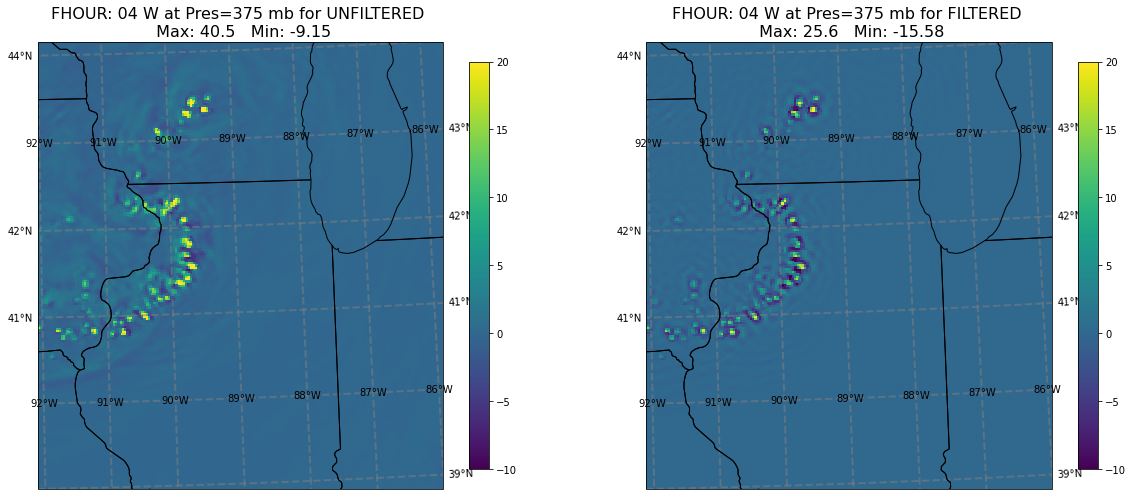

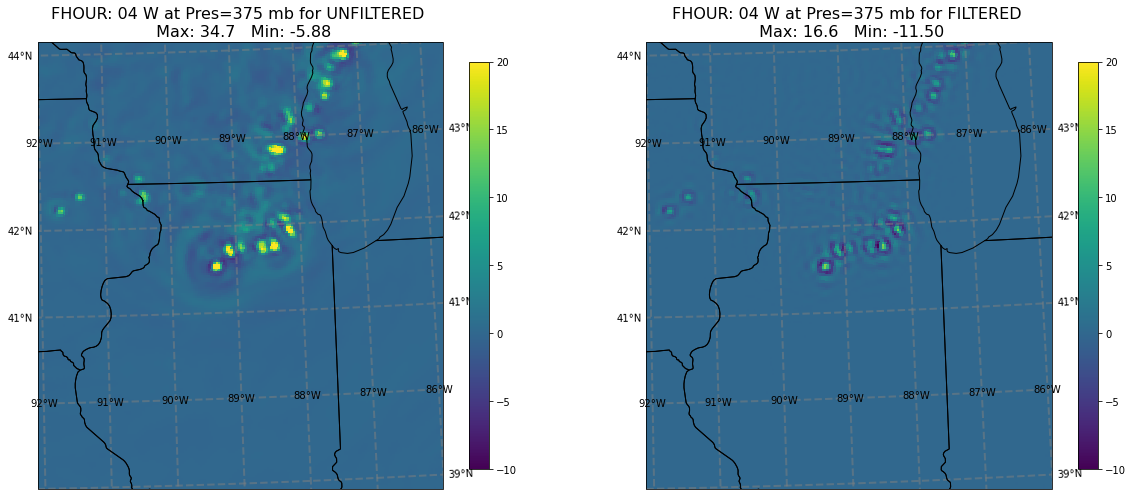

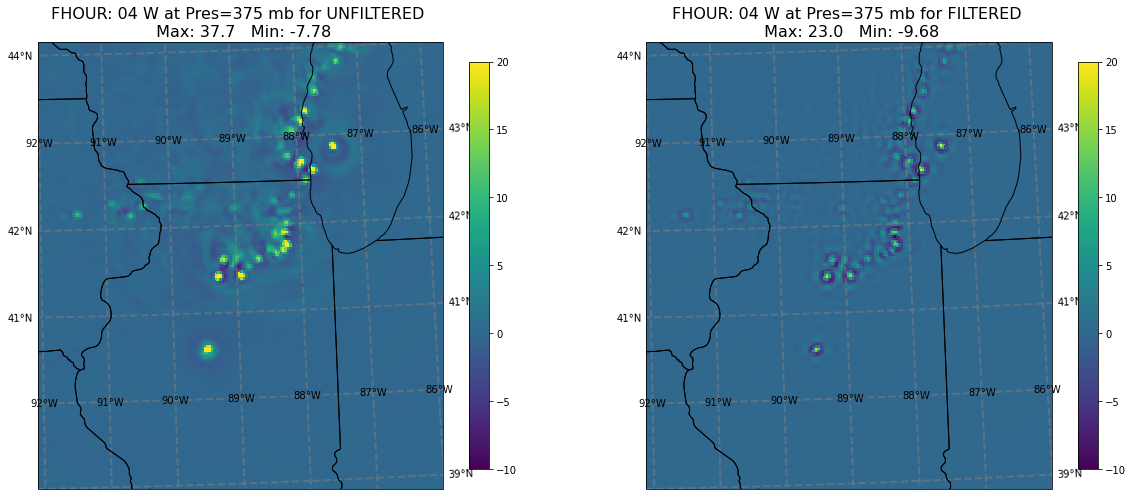

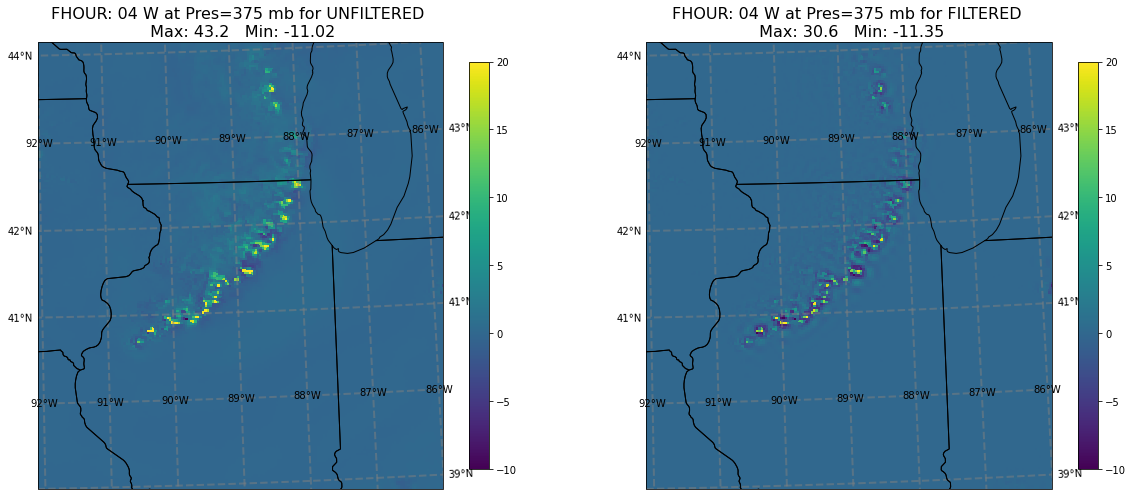

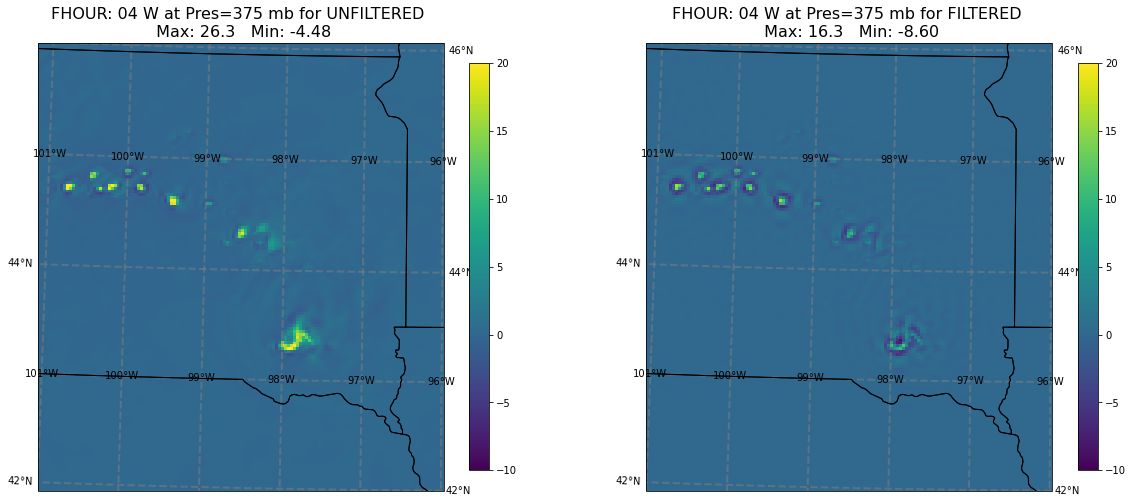

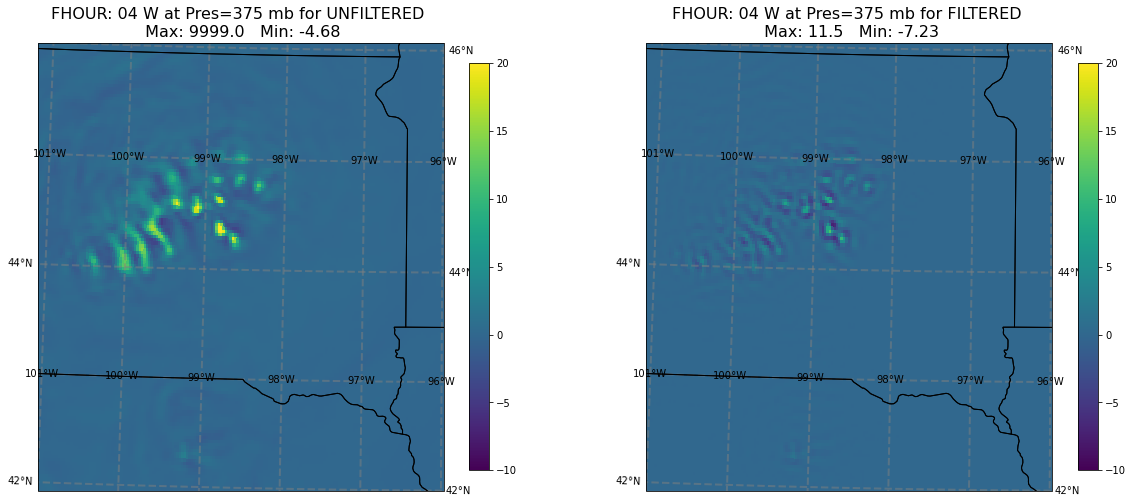

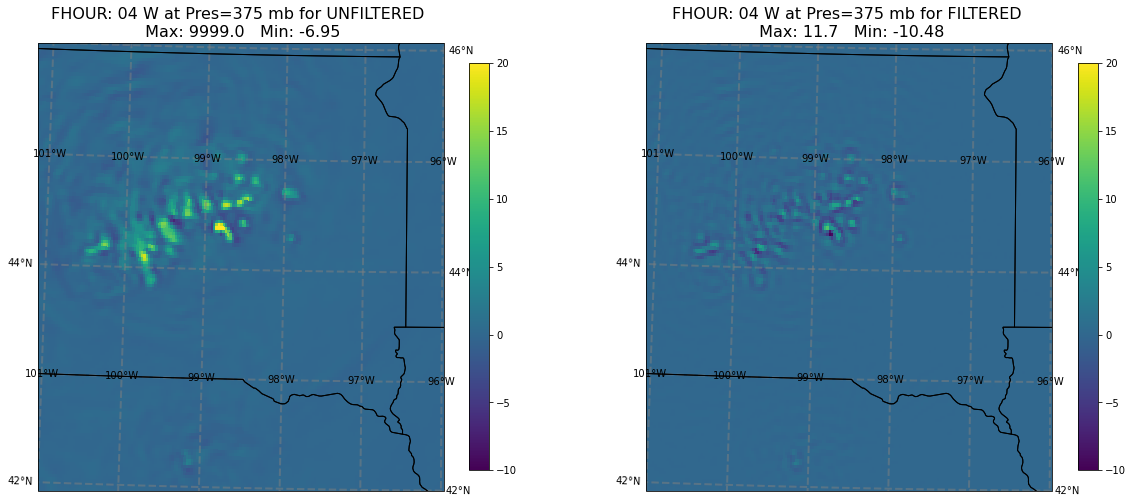

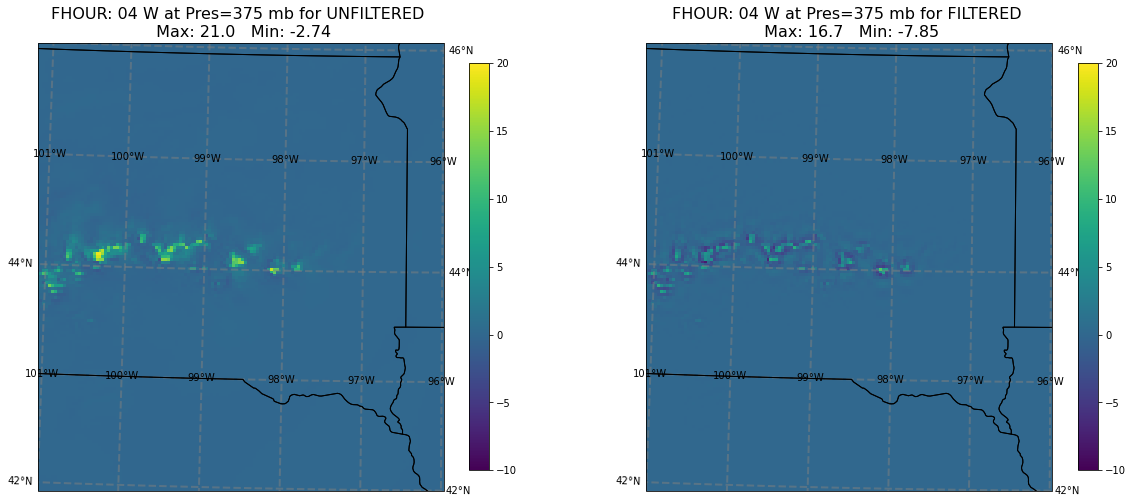

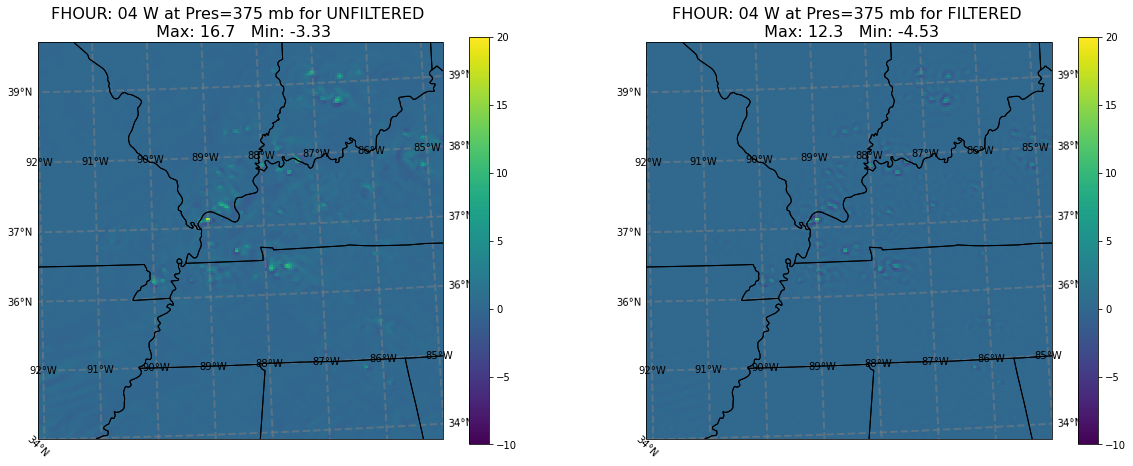

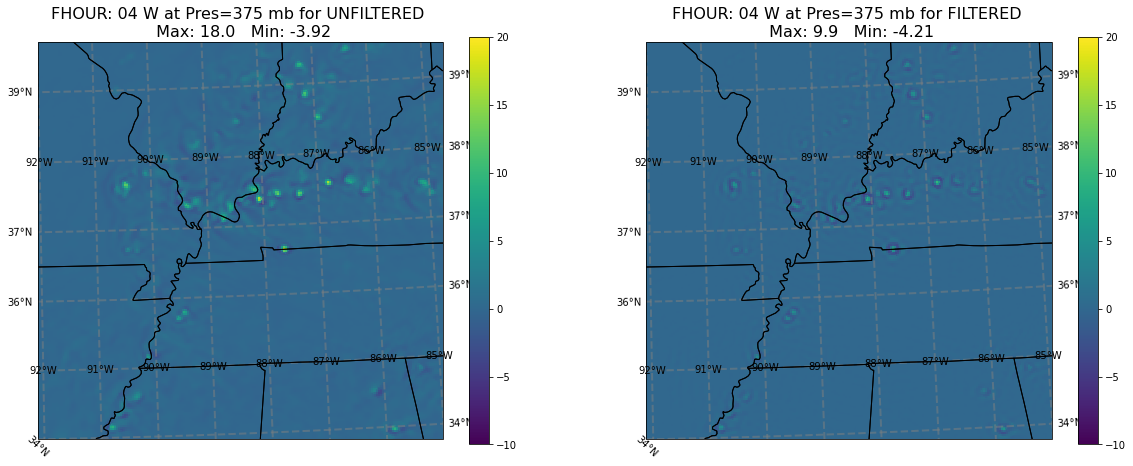

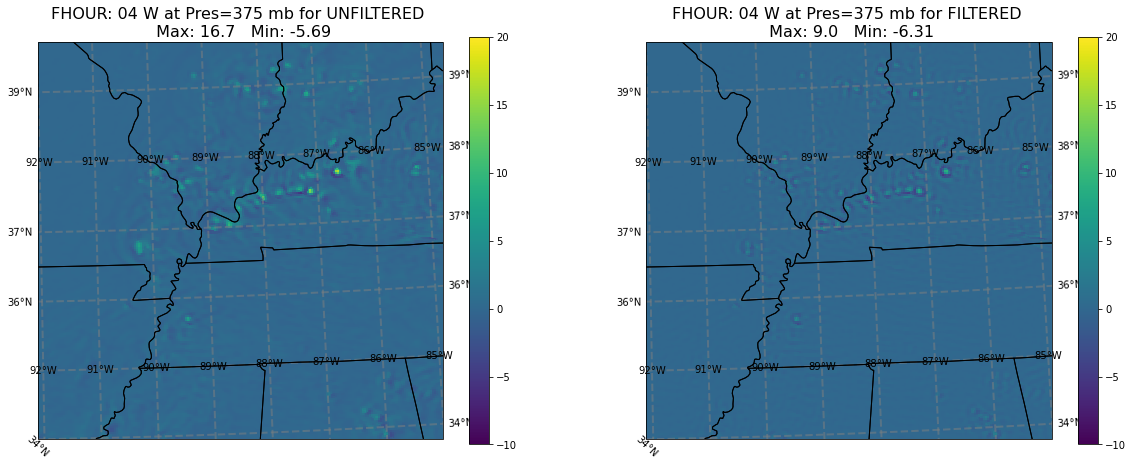

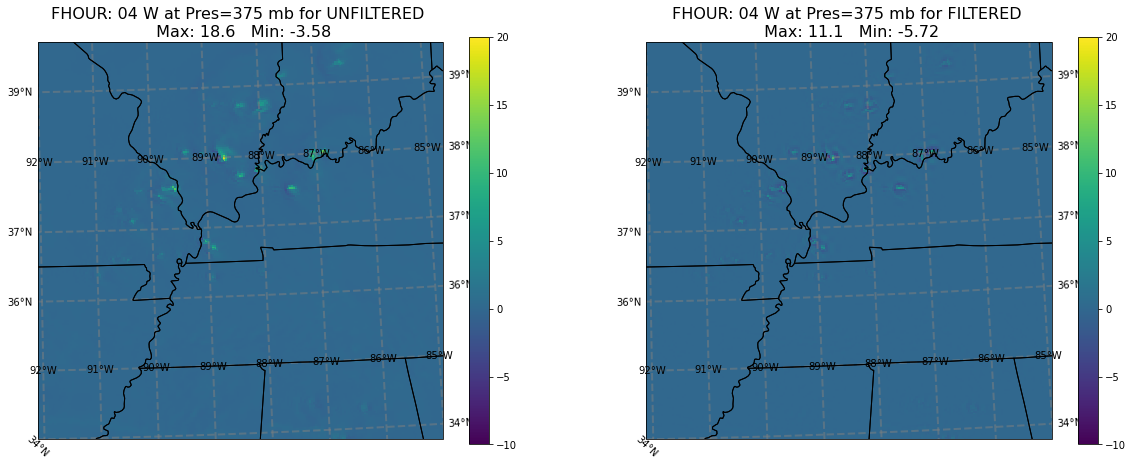

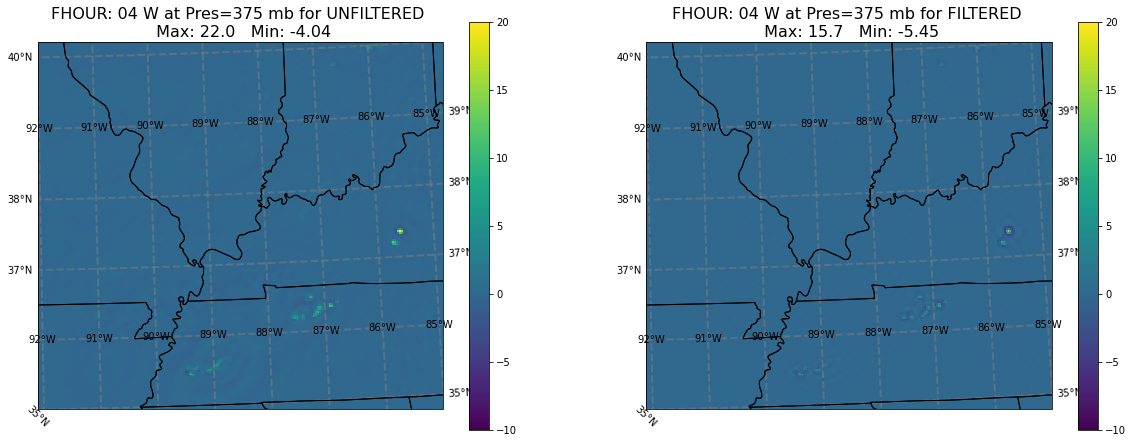

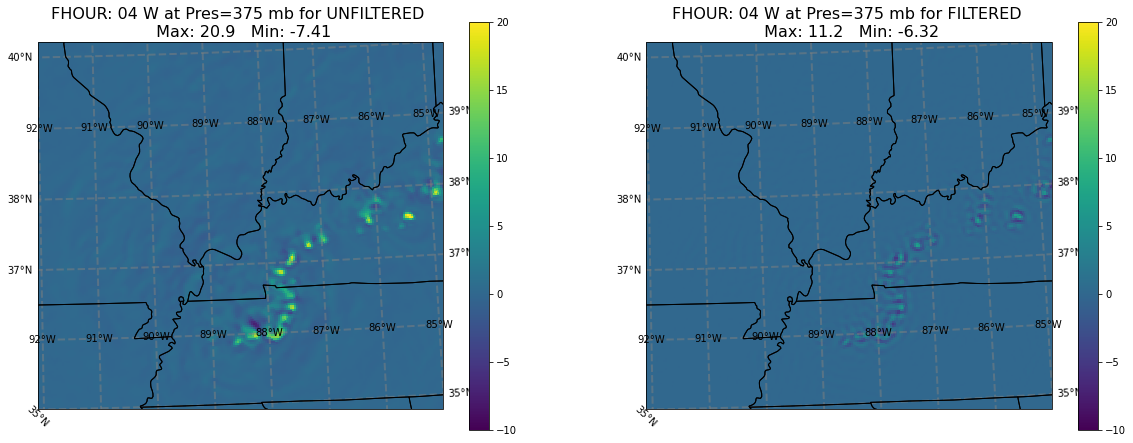

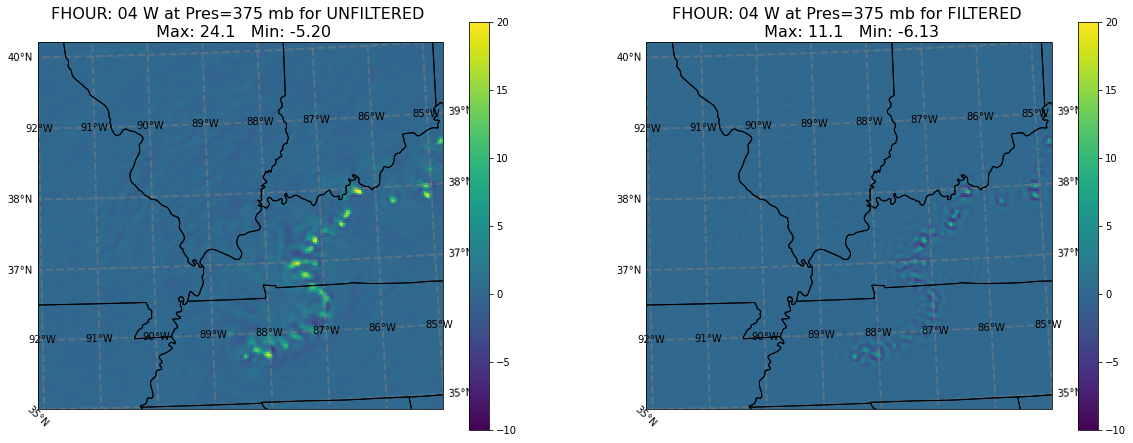

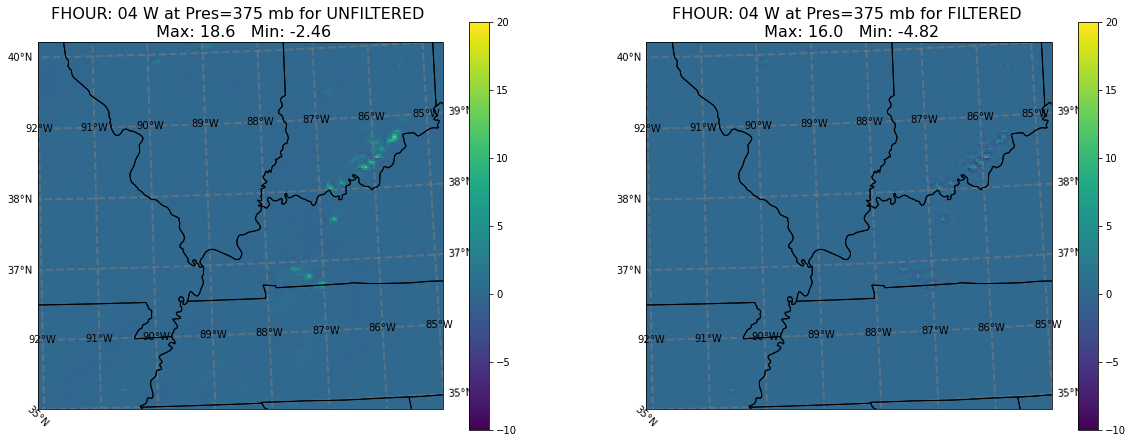

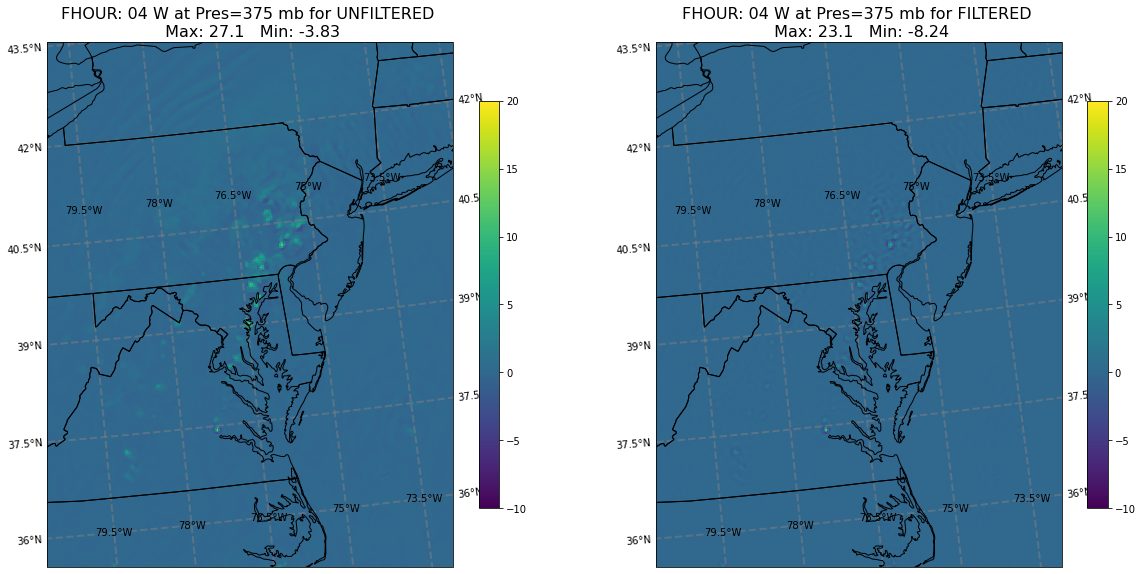

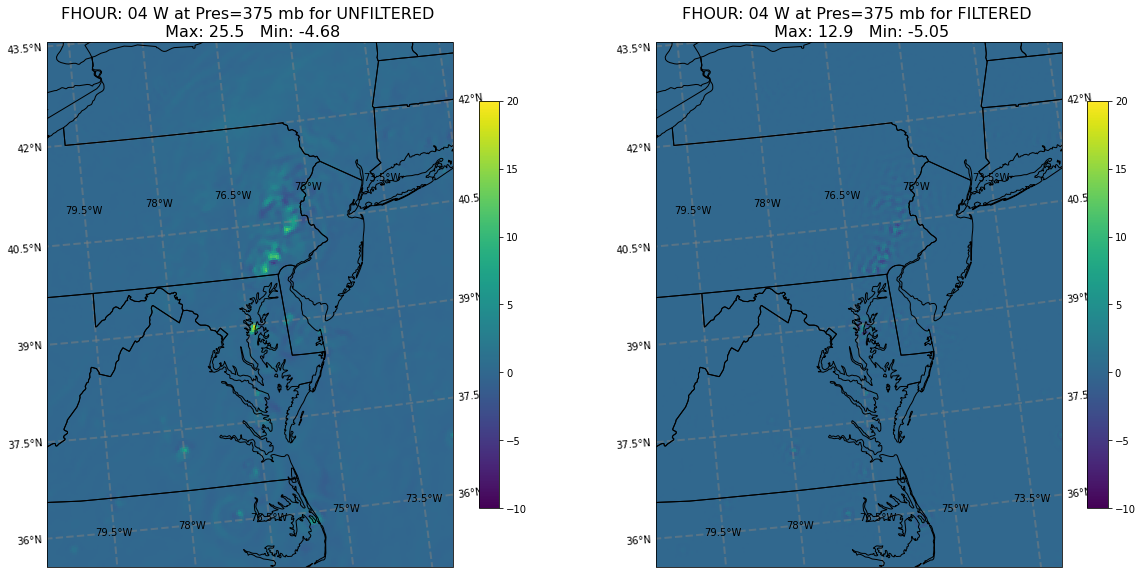

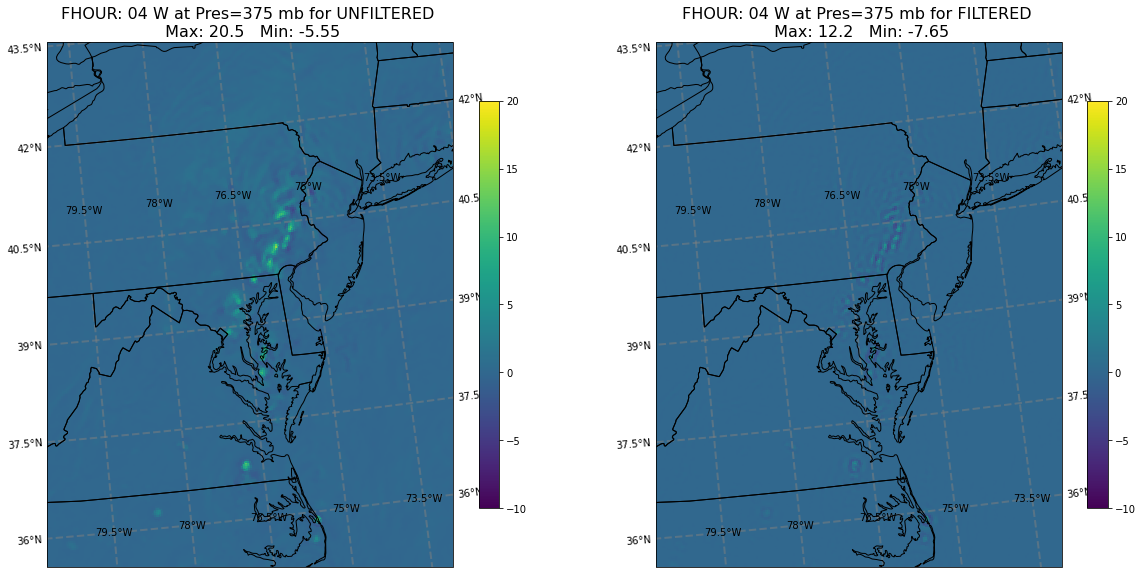

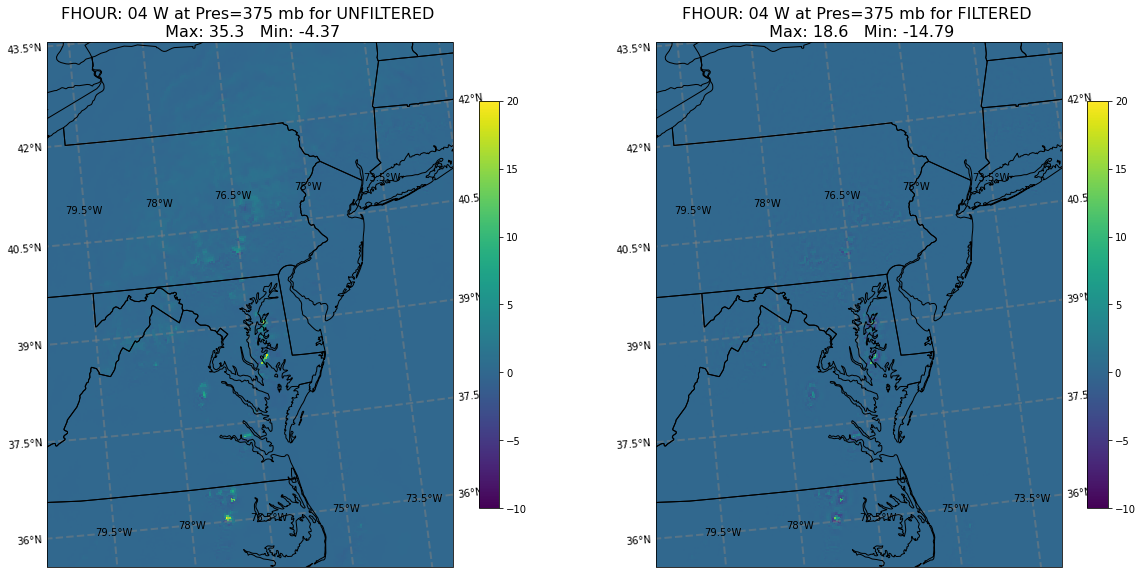

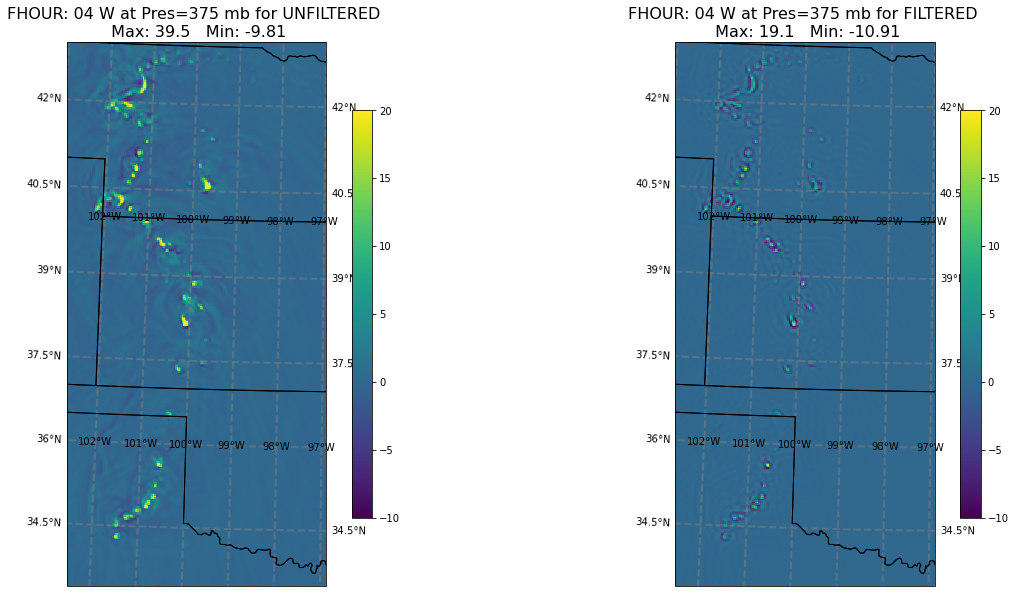

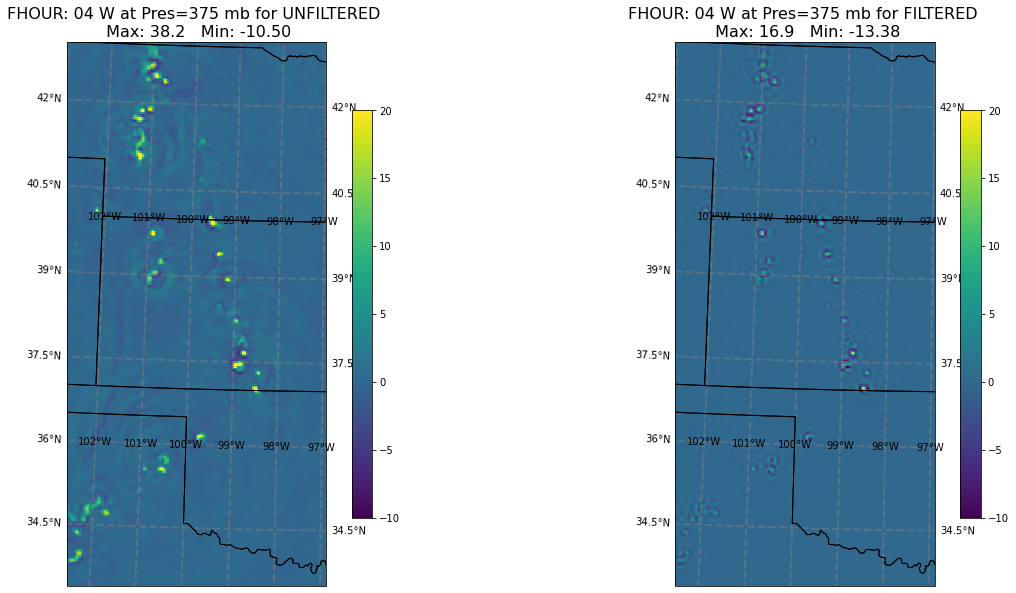

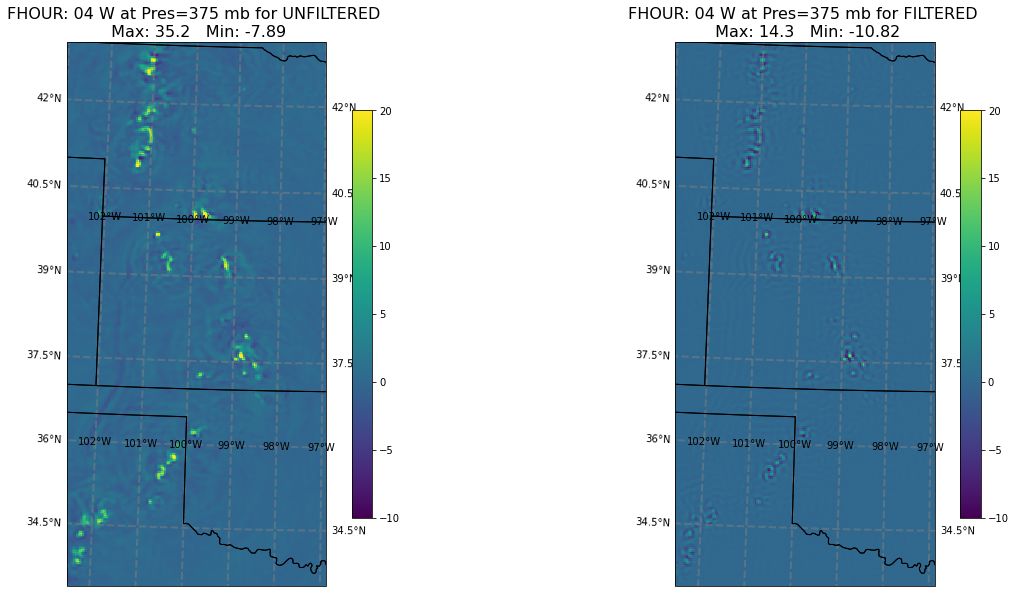

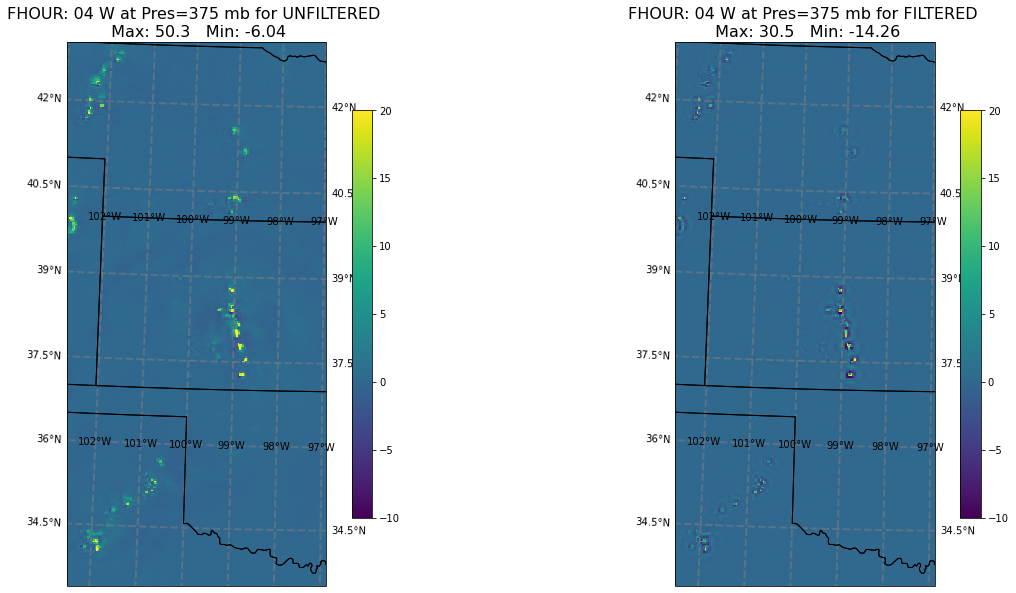

In [6]:
# Input data sets....

from input_default import input_all as input_config

input_dir         = input_config["input_dir"]
output_dir        = input_config["output_dir"]

filtered_filename = input_config["filtered_filename"]
filter_dx         = input_config["filter_dx"]
filter_npass      = input_config["filter_npass"]
filtered_dirname  = "W_%2.2i" % filter_dx
klevels           = input_config["klevels"]
fprefix           = input_config["fprefix"]
    
#------------------------------------------------------------------------------------
# cut and past from below here
#

print("\n====> Begin processing runs\n")

print("-------> Parameter Filter SCALE: %d \n" % filter_dx)
print("-------> Parameter        NPASS: %d \n" % filter_npass)
print("-------> Parameter FILTERED FILE DIRECTORY: %s \n" % filtered_filename)

for day in input_config["cases"]:
    
    # get zoom for plotting

    newlat = input_config["zoom"][day][0:2]
    newlon = input_config["zoom"][day][2:4]

    for run in input_config["cases"][day]:
        
        print("\n----> Processing run: %s for day:  %s \n" % (run,day))
        run_dir = str(os.path.join(input_dir, day, run))
        out_dir = str(os.path.join(output_dir, day, run, filtered_dirname))
        filter_ds(run_dir, out_dir, fprefix, dx=filter_dx, npass=filter_npass, writeout=True, newlat=newlat, newlon=newlon)
        
print("\n====> Ended processing runs\n")

del(input_config)


In [ ]:
import json

with open("sample.json", "w") as outfile:
    json.dump(input_spec, outfile)
    
import yaml
with open("sample.yaml", "w") as outfile:
    yaml.dump(input_spec, outfile)

In [141]:
with open("sample.yaml", "r") as outfile:
    d = yaml.load(outfile, Loader=yaml.FullLoader)
    
print(d)

{'cases': {'2019071918': ['hrrr', 'ctrl', 'nord3'], '2020081006': ['hrrr', 'ctrl', 'nord3']}, 'input_dir': '/Users/Louis.Wicker/CAM_Case_Studies', 'output_dir': '/Users/Louis.Wicker/CAM_Case_Studies'}


In [134]:
from input_default.py input 

Signature: yaml.load(stream, Loader)
Docstring:
Parse the first YAML document in a stream
and produce the corresponding Python object.
File:      ~/miniconda3/envs/mypip/lib/python3.9/site-packages/yaml/__init__.py
Type:      function


In [6]:
import importlib
importlib.*?

importlib.__all__
importlib.__builtins__
importlib.__cached__
importlib.__class__
importlib.__delattr__
importlib.__dict__
importlib.__dir__
importlib.__doc__
importlib.__eq__
importlib.__file__
importlib.__format__
importlib.__ge__
importlib.__getattribute__
importlib.__gt__
importlib.__hash__
importlib.__import__
importlib.__init__
importlib.__init_subclass__
importlib.__le__
importlib.__loader__
importlib.__lt__
importlib.__name__
importlib.__ne__
importlib.__new__
importlib.__package__
importlib.__path__
importlib.__reduce__
importlib.__reduce_ex__
importlib.__repr__
importlib.__setattr__
importlib.__sizeof__
importlib.__spec__
importlib.__str__
importlib.__subclasshook__
importlib.abc
importlib.find_loader
importlib.import_module
importlib.invalidate_caches
importlib.machinery
importlib.reload
importlib.sys
importlib.types
importlib.util
importlib.warnings

In [5]:
spec = importlib.util.find_spec("input_default.py")

ModuleNotFoundError: __path__ attribute not found on 'input_default' while trying to find 'input_default.py'

In [7]:
from input_default import input_all as input_config


In [21]:
import json

with open("sample.json", "w") as outfile:
    json.dump(input_config, outfile, sort_keys = True, indent = 4,
               ensure_ascii = False)

In [9]:
with open('sample.json', 'w', encoding='utf-8') as f:
    json.dump(input_config, f, ensure_ascii=False, indent=4)

In [20]:
import yaml
with open("sample.yaml", "r") as infile:
    yaml.dump(input_config)


In [29]:
with open('run_all.json') as data_file:    
    data = json.load(data_file)

JSONDecodeError: Expecting value: line 8 column 16 (char 207)

In [23]:
print(data)

{'cases': {'2020030212': ['hrrr', 'ctrl', 'nord3', 'nam'], '2020050300': ['hrrr', 'ctrl', 'nord3', 'nam'], '2020070700': ['hrrr', 'ctrl', 'nord3', 'nam'], '2020081006': ['hrrr', 'ctrl', 'nord3', 'nam'], '2021052612': ['hrrr', 'ctrl', 'nord3', 'nam'], '2021090100': ['hrrr', 'ctrl', 'nord3', 'nam']}, 'filter_dx': 12, 'filter_npass': 1, 'filtered_filename': '', 'fprefix': 'econus', 'input_dir': '/work/larissa.reames', 'klevels': None, 'output_dir': '/work/wicker/CAM_case_studies', 'writeout': True, 'zoom': {'2019071918': [44.0, 49.0, -92.0, -87.0, 5], '2020030212': [34.0, 39.5, -92.0, -85.0, 2], '2020050300': [35.0, 40.0, -92.0, -85.0, 5], '2020070700': [42.0, 46.0, -101.0, -96.0, 5], '2020081006': [39.0, 44.0, -92.0, -86.0, 5], '2021052612': [33.5, 43.0, -102.5, -97.0, 5], '2021090100': [35.5, 43.0, -80.0, -73.0, 5]}}


In [28]:
print(data['klevels'])

None


In [58]:
input_config =  {
              "filtered_filename": "",
              "filter_dx":          8,
              "filter_npass":       1,
              "input_dir":   "/work/wicker/CAM_case_studies",
              "output_dir":  "/work/wicker/CAM_case_studies",
              "fprefix":     "econus",
              "cases": {
                        "2020050300": ["ctrl", "nord3", "nam"],
                        "2020070700": ["hrrr", "ctrl", "nord3", "nam"],
                        "2021090100": ["hrrr", "ctrl", "nord3", "nam"],

                       },
               "zoom": {
                        "2019071918": [44.0, 49.0,  -92.0, -87.0, 5],
                        "2020081006": [39.0, 44.0,  -92.0, -86.0, 5],
                        "2020030212": [34.0, 39.5,  -92.0, -85.0, 2],
                        "2021090100": [35.5, 43.0,  -80.0, -73.0, 5],
                        "2020050300": [35.0, 40.0,  -92.0, -85.0, 5],
                        "2020070700": [42.0, 46.0, -101.0, -96.0, 5],
                        "2021052612": [33.5, 43.0, -102.5, -97.0, 5],
                        # "2021052612": [37.0, 40.5, -100., -97.5, 5]
                        }
                   }

def save_mfdataset_list(ds, dir, gridType=None):
    """
    Use xarray.save_mfdataset to save multiple netcdf files from a list, using the original file strings as a pattern
    """

    # Use new pathlib for Python > 3.5
    Path(dir).mkdir(parents=True, exist_ok=True)

    for n, hour in enumerate(ds.fhour):
        fcstHour  = ds.isel(fhour=n).fhour.values
        fcstStart = ds.isel(fhour=n).fcstStart
        date      = ds.isel(fhour=n).date      
        
        if gridType == None:
            gridType = ds.isel(fhour=n).attrs['gridType']
            
        outfilename = os.path.join(dir, '%s_%08d%04d_F%02d.nc' % (gridType, date, fcstStart, fcstHour))
        
        ds.isel(fhour=n).to_netcdf(outfilename, mode='w')  
        print(f'Successfully wrote new data to file:: {outfilename}','\n')
    
    return



input_dir         = input_config["input_dir"]
output_dir        = input_config["output_dir"]

filtered_filename = input_config["filtered_filename"]
filter_dx         = input_config["filter_dx"]
filtered_dirname  = "W_%2.2i" % filter_dx
fprefix           = "filtered"
    
#------------------------------------------------------------------------------------
# cut and past from below here
#

print("\n====> Begin processing runs\n")

print("-------> Parameter Filter SCALE: %d \n" % filter_dx)
print("-------> Parameter        NPASS: %d \n" % filter_npass)
print("-------> Parameter FILTERED FILE DIRECTORY: %s \n" % filtered_filename)

for day in input_config["cases"]:
    
    for run in input_config["cases"][day]:
        
        print("\n----> Processing run: %s for day:  %s \n" % (run,day))
        run_dir = str(os.path.join(input_dir, day, run, filtered_dirname))
        files = glob.glob(run_dir+"/filtered*.nc")
        for f in files:
            basename = os.path.basename(f)
            dirname  = os.path.dirname(f)
            splitname = basename.split('_')
            newname = "%s_%s00_%s" % (splitname[0], splitname[1], splitname[2])
            
            outname = str(os.path.join(output_dir, day, run, filtered_dirname, newname))
            print("%s %s %s" % ("mv", f, outname))
            os.system("%s %s %s" % ("mv", f, outname))
        
        # ds  = read_mfdataset_list(run_dir , "%s_*.nc" % fprefix)
        # save_mfdataset_list(ds, out_dir, gridType='filtered')
        
print("\n====> Ended processing runs\n")

del(input_config)


====> Begin processing runs

-------> Parameter Filter SCALE: 8 

-------> Parameter        NPASS: 1 

-------> Parameter FILTERED FILE DIRECTORY:  


----> Processing run: ctrl for day:  2020050300 

mv /work/wicker/CAM_case_studies/2020050300/ctrl/W_08/filtered_2020050300_F16.nc /work/wicker/CAM_case_studies/2020050300/ctrl/W_08/filtered_202005030000_F16.nc
mv /work/wicker/CAM_case_studies/2020050300/ctrl/W_08/filtered_2020050300_F17.nc /work/wicker/CAM_case_studies/2020050300/ctrl/W_08/filtered_202005030000_F17.nc
mv /work/wicker/CAM_case_studies/2020050300/ctrl/W_08/filtered_2020050300_F18.nc /work/wicker/CAM_case_studies/2020050300/ctrl/W_08/filtered_202005030000_F18.nc
mv /work/wicker/CAM_case_studies/2020050300/ctrl/W_08/filtered_2020050300_F20.nc /work/wicker/CAM_case_studies/2020050300/ctrl/W_08/filtered_202005030000_F20.nc
mv /work/wicker/CAM_case_studies/2020050300/ctrl/W_08/filtered_2020050300_F21.nc /work/wicker/CAM_case_studies/2020050300/ctrl/W_08/filtered_202005030000_

In [52]:
os.system?

Signature: os.system(command)
Docstring: Execute the command in a subshell.
Type:      builtin_function_or_method
